In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-tgfr6wk7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-tgfr6wk7
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached fvcore-0.1.5.post20221221.tar.gz (50 kB)
  Preparing metadata (setup.py) ... done
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
  Using cached black-23.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  Using cached antlr4-python3-runtime-4.9.3.tar.gz (117 kB)
  Preparing metadata (setup.py) ... done
  Using cached portalocker-2.8.2-py3-none-any.whl (17 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import json
from collections import Counter

def is_coco_format(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Check if the main keys are present
        if not all(key in data for key in ["images", "annotations", "categories"]):
            return False

        # Check if 'images' has the required keys
        for image in data["images"]:
            if not all(key in image for key in ["height", "width", "id", "file_name"]):
                return False

        # Check if 'annotations' has the required keys
        for annotation in data["annotations"]:
            if not all(key in annotation for key in ["iscrowd", "image_id", "bbox", "category_id", "id", "area"]):
                return False

        # Check if 'categories' has the required keys
        for category in data["categories"]:
            if not all(key in category for key in ["id", "name"]):
                return False

        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [ ]:
file_path = '/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json'
result = is_coco_format(file_path)
print(f"Is COCO Format: {result}")

Is COCO Format: True


In [ ]:
def count_category_distribution(file_path):
    """
    Count the distribution of category IDs in a given COCO format annotations file.

    Parameters:
    file_path (str): Path to the COCO format JSON file.

    Returns:
    Counter: A Counter object with the count of each category ID.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)

        category_ids = [annotation['category_id'] for annotation in data['annotations']]
        return Counter(category_ids)
    except Exception as e:
        return f"An error occurred: {e}"

# Usage
file_path = '/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json'
category_distribution = count_category_distribution(file_path)


In [ ]:
category_distribution

Counter({2: 2560, 6: 225, 3: 651, 1: 1806, 5: 494, 4: 475})

In [ ]:
import json
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def plot_examples_from_each_class(coco_json_path, images_directory):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Extract categories and annotations
    categories = {category['id']: category['name'] for category in coco_data['categories']}
    annotations = coco_data['annotations']

    # Group annotations by category
    category_to_annotations = {category: [] for category in categories.keys()}
    for annotation in annotations:
        category_to_annotations[annotation['category_id']].append(annotation)

    # Plotting one example per category
    for category_id, category_name in categories.items():
        # Randomly select an annotation for this category
        selected_annotation = random.choice(category_to_annotations[category_id])
        image_id = selected_annotation['image_id']
        image_info = next(item for item in coco_data['images'] if item['id'] == image_id)
        image_path = f"{images_directory}/{image_info['file_name']}"

        # Load and draw on image
        image = Image.open(image_path)
        draw = ImageDraw.Draw(image, 'RGBA')
        bbox = selected_annotation['bbox']
        segmentation = selected_annotation['segmentation'][0]

        # Draw bbox
        bbox_coords = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        draw.rectangle(bbox_coords, outline='red', width=3)

        # Draw segmentation
        segmentation_coords = [tuple(segmentation[i:i+2]) for i in range(0, len(segmentation), 2)]
        draw.polygon(segmentation_coords, outline='blue', fill=(255,255,255,100))

        # Show image
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Class: {category_name} (ID: {category_id})")
        plt.axis('off')
        plt.show()

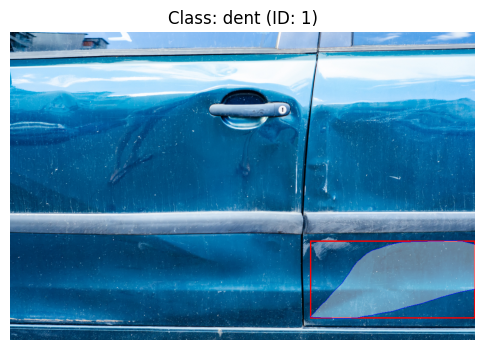

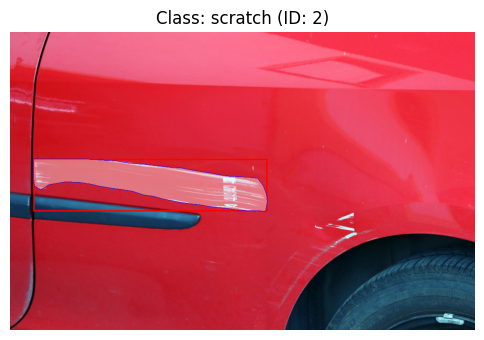

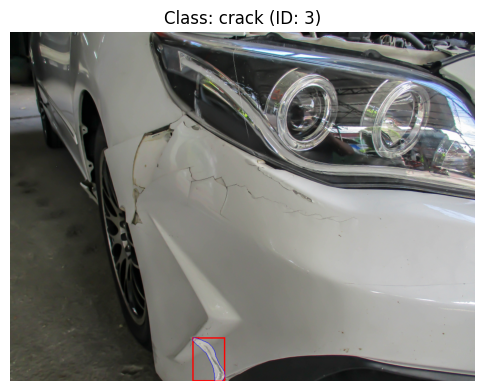

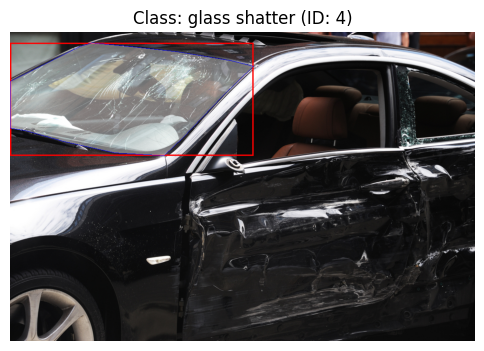

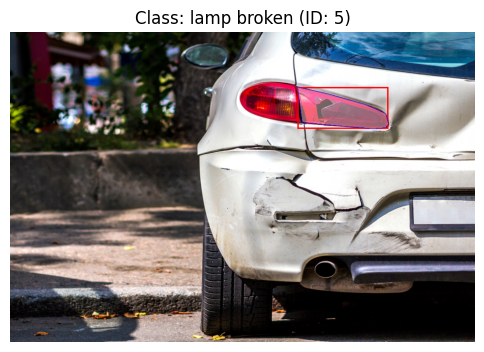

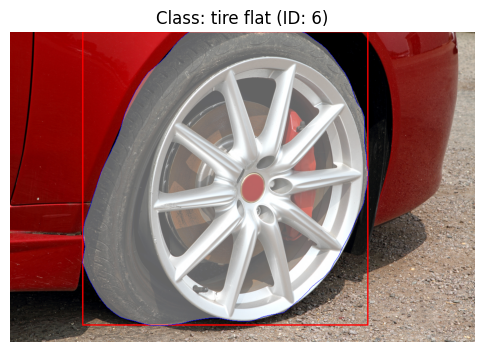

In [ ]:
plot_examples_from_each_class('/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json', '/content/drive/MyDrive/CarDD_release/CarDD_COCO/train2017')

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, '/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json', "/content/drive/MyDrive/CarDD_release/CarDD_COCO/train2017")

In [ ]:
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json", "/content/drive/MyDrive/CarDD_release/CarDD_COCO/val2017")

In [ ]:
from detectron2.data import DatasetCatalog

def is_dataset_registered(name):
    return name in DatasetCatalog.list()

dataset_name = "my_dataset_train"
if is_dataset_registered(dataset_name):
    print(f"The dataset '{dataset_name}' is registered.")
else:
    print(f"The dataset '{dataset_name}' is not registered.")

The dataset 'my_dataset_train' is registered.


[11/28 16:10:22 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json


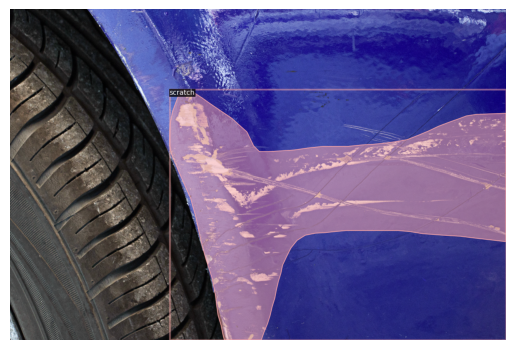

In [ ]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

# Load the dataset and retrieve metadata
dataset_dicts = DatasetCatalog.get(dataset_name)
dataset_metadata = MetadataCatalog.get(dataset_name)

# Pick a random sample from the dataset
sample = random.choice(dataset_dicts)

# Read the image
img = cv2.imread(sample["file_name"])

# Create a Visualizer object
visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata)

# Visualize the annotations
vis_output = visualizer.draw_dataset_dict(sample)

# Display the image using Matplotlib
plt.imshow(vis_output.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
import copy
import torch
from detectron2.data import detection_utils as utils

In [ ]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
        T.RandomRotation(angle=[90, 180, 270]),  # Simple rotation
        T.RandomContrast(0.8, 1.2),             # Random contrast
        T.RandomBrightness(0.8, 1.2),           # Random brightness
    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


In [ ]:
from detectron2.data import DatasetCatalog, build_detection_train_loader
import random
import copy

def custom_train_loader(cfg):
    # Load the dataset dicts for the training set
    dataset_dicts = get_balanced_dataset_dicts(cfg.DATASETS.TRAIN[0])
    return build_detection_train_loader(cfg, mapper=custom_mapper, dataset=dataset_dicts)

def get_balanced_dataset_dicts(dataset_name):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    oversample_factor = 3  # Setting the oversample factor to 3
    # Logic to duplicate entries of minority classes (4, 5, 6)
    balanced_dicts = []
    for d in dataset_dicts:
        if any(obj['category_id'] in [3, 4, 5, 6] for obj in d['annotations']):
            # Oversample these entries
            balanced_dicts.extend([copy.deepcopy(d)] * oversample_factor)  # Adjust the factor as needed
        else:
            balanced_dicts.append(d)
    random.shuffle(balanced_dicts)  # Important to shuffle for training
    return balanced_dicts

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import os

In [ ]:
class ReduceLROnPlateau:
    def __init__(self, optimizer, mode='min', factor=0.1, patience=10, threshold=1e-4, cooldown=0, min_lr=0, eps=1e-8):
        self.optimizer = optimizer
        self.mode = mode
        self.factor = factor
        self.patience = patience
        self.threshold = threshold
        self.cooldown = cooldown
        self.min_lr = min_lr
        self.eps = eps

        self._reset()

    def _reset(self):
        self.best = None
        self.num_bad_epochs = 0
        self.cooldown_counter = 0
        self.mode_worse = float('inf') if self.mode == 'min' else -float('inf')

    def step(self, metrics):
        current = float(metrics)

        if self.is_better(current, self.best):
            self.best = current
            self.num_bad_epochs = 0
        else:
            if self.cooldown_counter > 0:
                self.cooldown_counter -= 1
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1

        if self.num_bad_epochs > self.patience:
            self._reduce_lr()
            self.cooldown_counter = self.cooldown
            self.num_bad_epochs = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = float(param_group['lr'])
            new_lr = max(old_lr * self.factor, self.min_lr)
            if old_lr - new_lr > self.eps:
                param_group['lr'] = new_lr

    def is_better(self, current, best):
        if self.mode == 'min' and current < best - self.threshold:
            return True
        elif self.mode == 'max' and current > best + self.threshold:
            return False
        return False


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.events import EventStorage

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return custom_train_loader(cfg)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        # Use the COCO Evaluator
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    def validate(self):
        # Build the test loader
        val_loader = build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0])
        # Perform inference and evaluation
        return inference_on_dataset(self.model, val_loader, self.build_evaluator(self.cfg, self.cfg.DATASETS.TEST[0]))

    def train(self):
        """
        Run training with validation and early stopping.
        """
        early_stopping_patience = 10
        best_val_metric = None
        no_improvement_epochs = 0

        # Use the default training loop
        super().train()

        for data in self.train_loader:
            self.iter = self.iter + 1
            self.storage.put_scalar("iteration", self.iter, smoothing_hint=False)
            loss_dict = self.model(data)
            losses = sum(loss_dict.values())
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            self.storage.put_scalars(**{k: v.item() for k, v in loss_dict.items()})

            if self.iter % self.cfg.TEST.EVAL_PERIOD == 0 or self.iter == self.cfg.SOLVER.MAX_ITER:
                val_results = self.validate()
                val_metric = val_results['bbox']['AP']  # Use AP for bounding box as the metric

                if best_val_metric is None or val_metric > best_val_metric:
                    best_val_metric = val_metric
                    no_improvement_epochs = 0
                else:
                    no_improvement_epochs += 1

                if no_improvement_epochs >= early_stopping_patience:
                    print("Early stopping triggered due to no improvement in Average Precision")
                    break

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.events import EventStorage

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return custom_train_loader(cfg)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    def __init__(self, cfg):
        super().__init__(cfg)
        self.lr_scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min', factor=0.1, patience=10, threshold=0.0001,
            cooldown=0, min_lr=0, eps=1e-8
        )
        self.best_val_metric = None
        self.no_improvement_epochs = 0
        self.early_stopping_patience = 10

    def validate(self):
        val_loader = build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0])
        return inference_on_dataset(self.model, val_loader, self.build_evaluator(self.cfg, self.cfg.DATASETS.TEST[0]))

    def train(self):
        # Use the default training loop
        super().train()

        for data in self.train_loader:
            self.iter = self.iter + 1
            self.storage.put_scalar("iteration", self.iter, smoothing_hint=False)
            loss_dict = self.model(data)
            losses = sum(loss_dict.values())
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            self.storage.put_scalars(**{k: v.item() for k, v in loss_dict.items()})

            if self.iter % self.cfg.TEST.EVAL_PERIOD == 0 or self.iter == self.cfg.SOLVER.MAX_ITER:
                val_results = self.validate()
                val_metric = val_results['bbox']['AP']  # Example metric

                # Step the LR scheduler
                self.lr_scheduler.step(val_metric)

                # Check and update best_val_metric
                if self.best_val_metric is None or val_metric > self.best_val_metric:
                    self.best_val_metric = val_metric
                    self.no_improvement_epochs = 0
                else:
                    self.no_improvement_epochs += 1

                # Early stopping check
                if self.no_improvement_epochs >= self.early_stopping_patience:
                    print("Early stopping triggered due to no improvement in Average Precision")
                    break


In [ ]:
# Define hyperparameters
batch_size = 4  # Example batch size

# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = 0.00025  # Starting learning rate
cfg.TEST.EVAL_PERIOD = 500
cfg.SOLVER.MAX_ITER = 4000
cfg.SOLVER.STEPS = (1000, 2000, 3000)  # Decrease at these iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

# Learning rate scheduler configuration
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.GAMMA = 0.1  # Learning rate reduction factor
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.WEIGHT_DECAY = 0.001  # Regularization - weight decay

# Set up output directory
output_dir = "/content/drive/MyDrive/output1"
os.makedirs(output_dir, exist_ok=True)
cfg.OUTPUT_DIR = output_dir

# Initialize the trainer and start training
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
from collections import Counter

def analyze_dataset_distribution(dataset_dicts):
    category_counts = Counter()
    for d in dataset_dicts:
        for annotation in d['annotations']:
            category_id = annotation['category_id']
            category_counts[category_id] += 1
    return category_counts

# Load your balanced dataset
balanced_dataset_dicts = get_balanced_dataset_dicts(cfg.DATASETS.TRAIN[0])

# Analyze the distribution
category_counts = analyze_dataset_distribution(balanced_dataset_dicts)
print("Category distribution in the dataset:", category_counts)

[11/28 16:10:24 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json
Category distribution in the dataset: Counter({1: 3508, 0: 3060, 4: 1482, 3: 1425, 2: 1211, 5: 675})


[11/28 16:11:36 d2.data.datasets.coco]: Loaded 810 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json


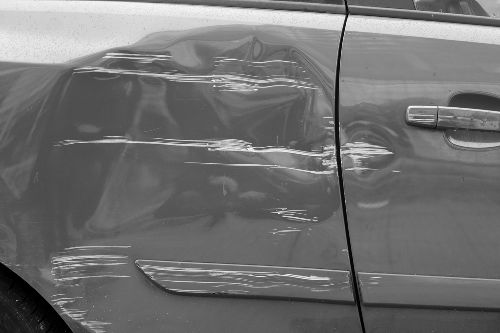

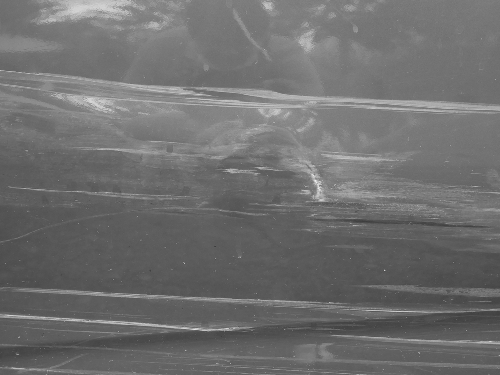

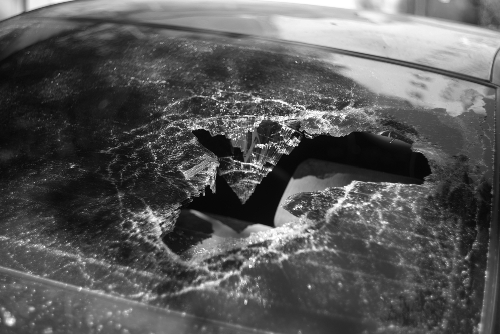

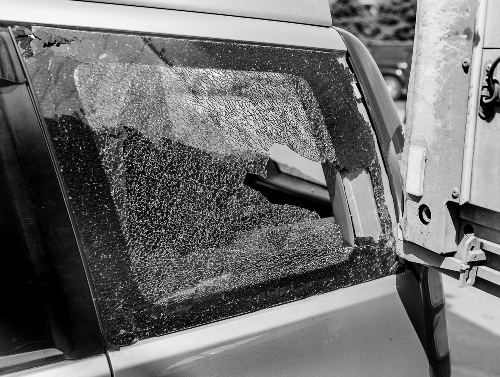

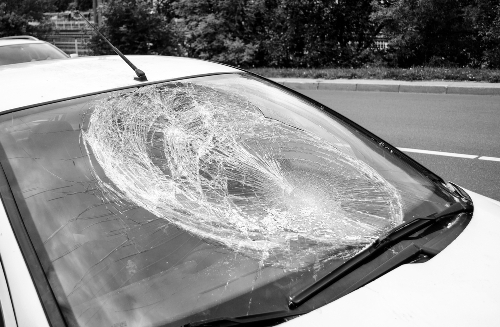

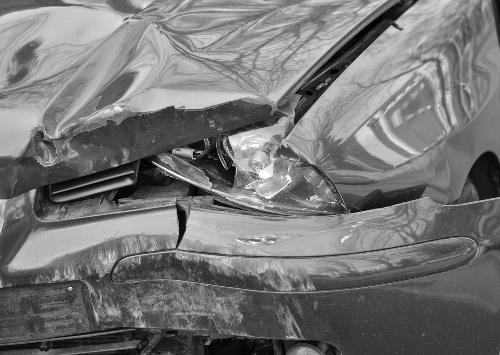

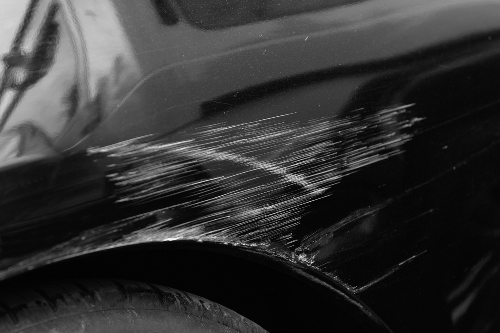

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from google.colab.patches import cv2_imshow
import random
import cv2

# Name of the validation dataset
dataset_name = "my_dataset_val"

# Load the dataset
dataset_dicts = DatasetCatalog.get(dataset_name)

# Retrieve metadata
dataset_metadata = MetadataCatalog.get(dataset_name)

# Using the predictor to make predictions
for d in random.sample(dataset_dicts, 7):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

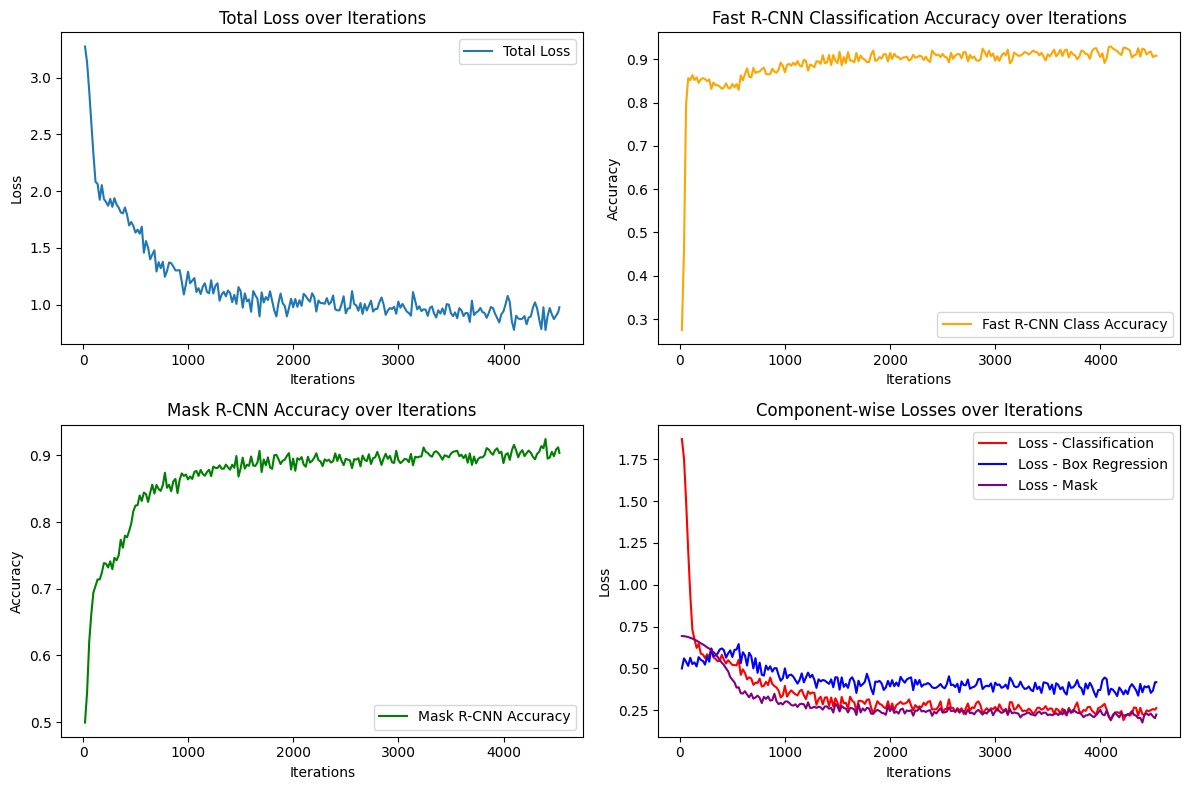

In [ ]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict

# Path to your metrics.json file
metrics_file = '/content/drive/MyDrive/output1/metrics.json'  # Update this path

# Read the file and parse the JSON
with open(metrics_file, 'r') as file:
    lines = file.readlines()

metrics = [json.loads(line) for line in lines]

# Data structure to store aggregated metrics
aggregated_metrics = defaultdict(lambda: defaultdict(list))

# Aggregate metrics
for m in metrics:
    if all(k in m for k in ['iteration', 'total_loss', 'fast_rcnn/cls_accuracy', 'mask_rcnn/accuracy', 'loss_cls', 'loss_box_reg', 'loss_mask']):
        iteration = m['iteration']
        aggregated_metrics[iteration]['total_loss'].append(m['total_loss'])
        aggregated_metrics[iteration]['cls_accuracy'].append(m['fast_rcnn/cls_accuracy'])
        aggregated_metrics[iteration]['mask_accuracy'].append(m['mask_rcnn/accuracy'])
        aggregated_metrics[iteration]['loss_cls'].append(m['loss_cls'])
        aggregated_metrics[iteration]['loss_box_reg'].append(m['loss_box_reg'])
        aggregated_metrics[iteration]['loss_mask'].append(m['loss_mask'])

# Compute averages for each iteration
averaged_metrics = defaultdict(dict)
for iteration, metrics in aggregated_metrics.items():
    for metric, values in metrics.items():
        averaged_metrics[iteration][metric] = sum(values) / len(values)

# Separate metrics for plotting
iterations = sorted(averaged_metrics.keys())
total_losses = [averaged_metrics[i]['total_loss'] for i in iterations]
cls_accuracies = [averaged_metrics[i]['cls_accuracy'] for i in iterations]
mask_accuracies = [averaged_metrics[i]['mask_accuracy'] for i in iterations]
loss_cls = [averaged_metrics[i]['loss_cls'] for i in iterations]
loss_box_reg = [averaged_metrics[i]['loss_box_reg'] for i in iterations]
loss_mask = [averaged_metrics[i]['loss_mask'] for i in iterations]

# Plotting
plt.figure(figsize=(12, 8))

# Total loss
plt.subplot(2, 2, 1)
plt.plot(iterations, total_losses, label='Total Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Total Loss over Iterations')
plt.legend()

# Classification Accuracy
plt.subplot(2, 2, 2)
plt.plot(iterations, cls_accuracies, label='Fast R-CNN Class Accuracy', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Fast R-CNN Classification Accuracy over Iterations')
plt.legend()

# Mask Accuracy
plt.subplot(2, 2, 3)
plt.plot(iterations, mask_accuracies, label='Mask R-CNN Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Mask R-CNN Accuracy over Iterations')
plt.legend()

# Losses for Classification, Box Regression, and Mask
plt.subplot(2, 2, 4)
plt.plot(iterations, loss_cls, label='Loss - Classification', color='red')
plt.plot(iterations, loss_box_reg, label='Loss - Box Regression', color='blue')
plt.plot(iterations, loss_mask, label='Loss - Mask', color='purple')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Component-wise Losses over Iterations')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Initialize the configuration
cfg = get_cfg()

# Load the base configuration from model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set the path to the trained model weights
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/output1/model_final.pth"

# Set the number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Update this based on your dataset

# Set the testing threshold for this model (adjust as needed)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# Specify the test dataset
cfg.DATASETS.TEST = ("my_dataset_val",)

In [ ]:
from detectron2.engine import DefaultPredictor
predictor = DefaultPredictor(cfg)

[11/28 16:22:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output1/model_final.pth ...


[11/28 16:22:37 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json
Confidence scores of detected instances: tensor([0.8413, 0.7836], device='cuda:0')


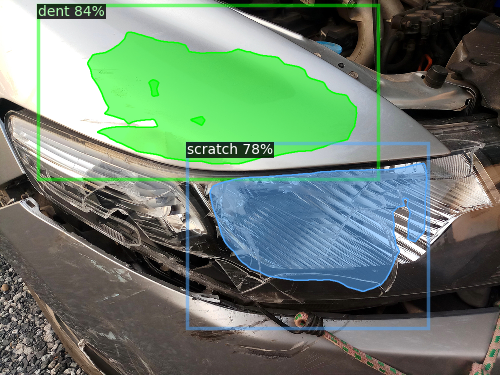

In [ ]:
import cv2
import random
from detectron2.utils.visualizer import Visualizer, ColorMode
from google.colab.patches import cv2_imshow

# Assuming cfg and predictor are already set up as in your previous code

# Load the validation dataset
dataset_dicts = DatasetCatalog.get("my_dataset_train")
dataset_metadata = MetadataCatalog.get("my_dataset_train")

# Select a few random samples from the dataset
for d in random.sample(dataset_dicts, 3):  # Reduced number for quicker testing
    # Read the image
    im = cv2.imread(d["file_name"])
    if im is None:
        print(f"Failed to read image {d['file_name']}")
        continue

    # Make prediction
    outputs = predictor(im)

    # Check if there are any instances detected
    instances = outputs["instances"]
    if len(instances) == 0:
        print("No instances detected in the image.")
        continue

    # Display confidence scores
    scores = instances.scores if instances.has("scores") else None
    if scores is not None:
        print("Confidence scores of detected instances:", scores)

    # Visualize the prediction
    v = Visualizer(im[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

    # Optionally, break after the first image for detailed analysis
    break


[11/28 16:22:39 d2.data.datasets.coco]: Loaded 810 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json


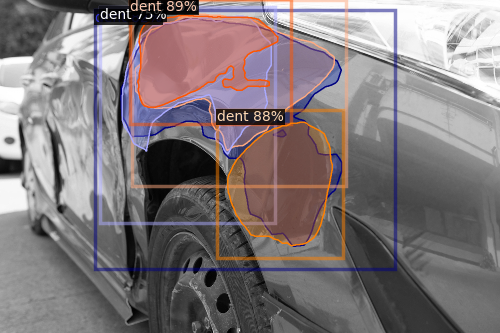

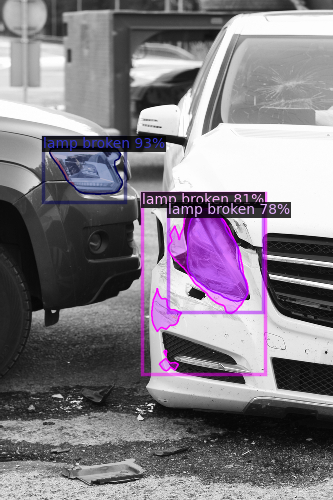

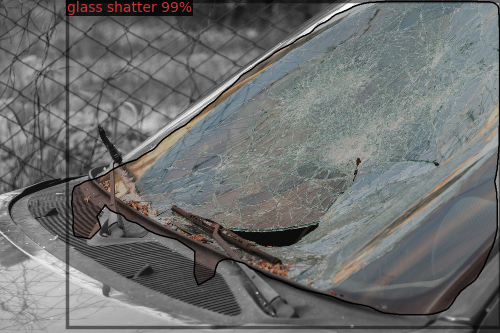

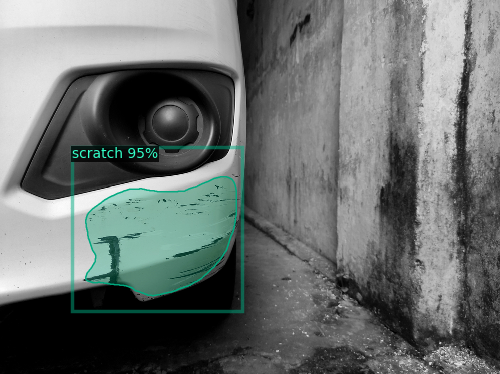

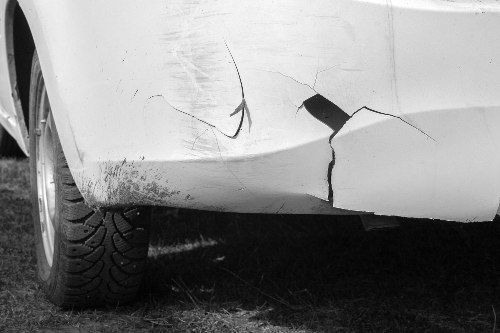

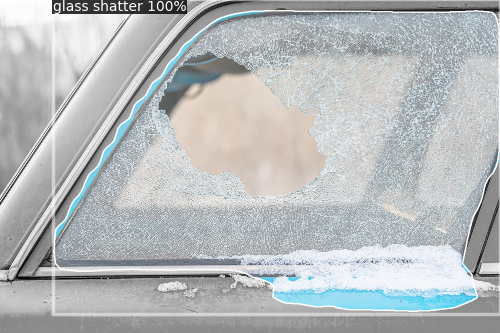

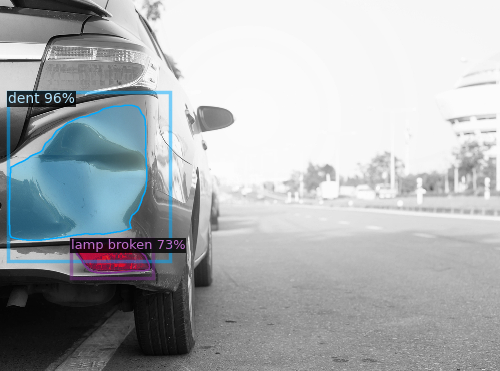

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from google.colab.patches import cv2_imshow
import random
import cv2

# Name of the validation dataset
dataset_name = "my_dataset_val"

# Load the dataset
dataset_dicts = DatasetCatalog.get(dataset_name)

# Retrieve metadata
dataset_metadata = MetadataCatalog.get(dataset_name)

# Using the predictor to make predictions
for d in random.sample(dataset_dicts, 7):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


# Register your test dataset in Detectron2's dataset catalog if not already done
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_test2017.json", "/content/drive/MyDrive/CarDD_release/CarDD_COCO/test2017")



In [ ]:
# Create a COCOEvaluator instance for your test dataset
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/content/drive/MyDrive/output1/evaluation")

# Build the test data loader
test_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Run the model on the test data and get the evaluation metrics
inference_on_dataset(predictor.model, test_loader, evaluator)

WARNING [11/28 16:35:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/28 16:35:49 d2.data.datasets.coco]: Loaded 810 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json
[11/28 16:35:49 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
|     dent      | 501          |   scratch   | 728          |   crack    | 177          |
| glass shatter | 135          | lamp broken | 141          | tire flat  | 62           |
|               |              |             |              |            |              |
|     total     | 1744         |             |              |            |              |
[11/28 16:35:49 d2.data.dataset_mapper]: [Datas

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[11/28 16:35:57 d2.evaluation.evaluator]: Inference done 11/810. Dataloading: 0.0073 s/iter. Inference: 0.5261 s/iter. Eval: 0.0435 s/iter. Total: 0.5769 s/iter. ETA=0:07:40
[11/28 16:36:02 d2.evaluation.evaluator]: Inference done 33/810. Dataloading: 0.0581 s/iter. Inference: 0.2470 s/iter. Eval: 0.0131 s/iter. Total: 0.3187 s/iter. ETA=0:04:07
[11/28 16:36:07 d2.evaluation.evaluator]: Inference done 53/810. Dataloading: 0.0835 s/iter. Inference: 0.2004 s/iter. Eval: 0.0086 s/iter. Total: 0.2929 s/iter. ETA=0:03:41
[11/28 16:36:13 d2.evaluation.evaluator]: Inference done 69/810. Dataloading: 0.1049 s/iter. Inference: 0.1907 s/iter. Eval: 0.0075 s/iter. Total: 0.3034 s/iter. ETA=0:03:44
[11/28 16:36:18 d2.evaluation.evaluator]: Inference done 89/810. Dataloading: 0.1092 s/iter. Inference: 0.1790 s/iter. Eval: 0.0069 s/iter. Total: 0.2953 s/iter. ETA=0:03:32
[11/28 16:36:23 d2.evaluation.evaluator]: Inference done 107/810. Dataloading: 0.1195 s/iter. Inference: 0.1704 s/iter. Eval: 0.00

OrderedDict([('bbox',
              {'AP': 20.811471127441408,
               'AP50': 43.50445265994111,
               'AP75': 14.901884171545433,
               'APs': 0.0,
               'APm': 0.5726841851249944,
               'APl': 21.451732043186887,
               'AP-dent': 2.9834280240069044,
               'AP-scratch': 5.602837165633096,
               'AP-crack': 0.0,
               'AP-glass shatter': 64.06133255985802,
               'AP-lamp broken': 22.30223553915625,
               'AP-tire flat': 29.918993475994178}),
             ('segm',
              {'AP': 34.47041989237242,
               'AP50': 44.77439658910833,
               'AP75': 37.47441749243141,
               'APs': 0.0,
               'APm': 0.5147257239803302,
               'APl': 35.7144407565119,
               'AP-dent': 5.0383233754253505,
               'AP-scratch': 8.692398223566256,
               'AP-crack': 0.0,
               'AP-glass shatter': 82.86976919981717,
               'AP-la

In [ ]:
# Reload the original dataset
with open('/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json', 'r') as file:
    data = json.load(file)

# Filtering the categories to keep only ids 1, 2, and 3
filtered_categories = [category for category in data['categories'] if category['id'] in [1, 2, 3]]

# Filtering the annotations to keep only those related to the selected categories
filtered_annotations = [annotation for annotation in data['annotations'] if annotation['category_id'] in [1, 2, 3]]

# Checking for unwanted category ids (4, 5, 6)
unwanted_ids = [4, 5, 6]
unwanted_annotations = [annotation for annotation in data['annotations'] if annotation['category_id'] in unwanted_ids]

# Keeping the images that have annotations after filtering
image_ids = set([annotation['image_id'] for annotation in filtered_annotations])
filtered_images = [image for image in data['images'] if image['id'] in image_ids]

# Preparing the new dataset
new_dataset = {
    'info': data['info'],
    'licenses': data['licenses'],
    'images': filtered_images,
    'annotations': filtered_annotations,
    'categories': filtered_categories
}

# Saving the new dataset
new_file_path = 'adjusted_instances_val2017.json'
with open(new_file_path, 'w') as file:
    json.dump(new_dataset, file, indent=4)

# Results
new_file_path, len(unwanted_annotations)

('adjusted_instances_val2017.json', 338)